<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT23/blob/main/Lab3/reinisfreibergs_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: approximation
**Reinis Freibergs**

# **Abstract**

In this lab assignment the goal is to use the L2 projection to find piecewise linear approximation of some function over mesh in 1D. The assembly algorithm is used for looping over individual subintervals of the mesh and in the end it's tested with different order polynomials with various mesh sizes.
The results indicate successful convergence.

# **About the code**

In [69]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""


# Author: Reinis Freibergs, 2023

# Based on a template:
# Copyright (C) 2023 Johan Hoffman (jhoffman@kth.se)


# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [70]:
# Load neccessary modules.
#from google.colab import files

import numpy as np
import matplotlib.pyplot as plt

# **Introduction**

One method to approximate functions is the L2 projection - it constructs the approximations using orthogonal projections, which are the best possible approximations of the function $f$ in the functional subspace $V_N$ with respect to the L2 norm.
The L2 projection $P_Nf$ onto the space of continous piecewise linear polynomials $V_h^{(1)}$ of the interval $I = [0, 1]$ with $m$ internal nodes is given by the equation 9.18 from the book:

$$P_hf(x) = \sum^{m+1}_{j=0} \alpha_j\phi_j(x)$$

where $\alpha$ are the coordinates and $\phi$ the basis spanning $V_N$.
Further the coordinates can be determined from the matrix equation (9.19):

$$A\alpha = B$$

where $A = (a_{ij})$ is the mass matrix defined by $(\phi_j, \phi_i)$ and the load vector $b = (b_i)$ with $b_i = (f, \phi_i)$
The entries of the load vector can be evaluated analitically (given in example 9.8):

$$\alpha_{kk} = \frac{h_k}{3} + \frac{h_{k+1}}{3}, $$
$$\alpha_{k, k+1} = \frac{h_{k+1}}{6}$$
$$\alpha_{k, k-1} = \frac{h_k}{6}$$

Which for uniform subdivision of the interval with $h_{k-1} = h_k = h_{k+1}$ gives a tridiagonal symmetric positive matrix.

Then the load vector $b_k$ is given by:

$$b_k = (f, \phi_k) = \int_0^1 f(x)\phi_k(x)dx$$

As based on lecture notes on FEM by D.Hanning (available at http://www.it.uu.se/edu/course/homepage/fem/ht13/skript) the integral can be expressed numerically with the trapezoidal rule:

$$b_i \approx f(x_i)\frac{h_i - h_{i-1}}{2}$$

and in case the intervals are equal $h_i = h_{i-1} = h$ the function is given as just $b_i \approx f(x_i)\cdot h_i$

The mass matrix can be further analyzed. Using the previously found analytical solutions the matrix can be written in the localized structure:

$$ \begin{bmatrix}
\frac{h_1}{3} & \frac{h_1}{6} & 0 & ... & 0 \\
\frac{h_1}{6} & \frac{h_1}{3}+\frac{h_2}{3} & \frac{h_6}{6} & ... & 0 \\
0 & ... & ... & ... & \frac{h_N}{6} \\
... & ... & 0 & \frac{h_N}{6} & \frac{h_N}{3} \\
\end{bmatrix}$$

Thus it can be seen that the calculation can be done for a single element at a time. This will be done by using the assembly algorithm 9.2

$$
M = \begin{bmatrix}
\frac{h_1}{3} & \frac{h_1}{6}\\
\frac{h_1}{6} & \frac{h_1}{3}\\
 & & &
\end{bmatrix} +
\begin{bmatrix}
 & & &\\
 &\frac{h_2}{3} & \frac{h_2}{6}\\
 &\frac{h_2}{6} & \frac{h_2}{3}
\end{bmatrix} + ...
$$



# **Methods**

The algorithms below directly use the structure of the assembly algorithm 9.2

In [74]:
def get_local_to_global_map(k):
    return np.array([k, k+1])


def get_no_local_shape_functions(k):
    # linear
    return 1


def integrate_vector(f, i, points, loc2glob):
    a, b = loc2glob[0], loc2glob[1]
    h = abs(points[b] - points[a])

    if i == 0:
        return f(points[a]) * h/2
    else:
        return f(points[b]) * h/2


def integrate_matrix(loc2glob, i, j, points):
    a, b = loc2glob[0], loc2glob[1]
    h = abs(points[b] - points[a])
    
    if i == j:
        return h/3
    elif np.abs(i - j) == 1:
        return h/6

def add_to_global_vector(B, b_k, loc2glob):
    a, b = loc2glob[0], loc2glob[1]

    B[a] += b_k[0]
    B[b] += b_k[1]
    
    return B

def add_to_global_matrix(A, a_k, loc2glob):
    a, b = loc2glob[0], loc2glob[1]

    A[a, a] += a_k[0, 0]
    A[b, b] += a_k[1, 1]
    A[a, b] += a_k[0, 1]
    A[b, a] += a_k[1, 0]

    return A

def assemble_system(f, points, A, b):
    point_count = len(points)

    for k in range(point_count - 1):
        q = get_no_local_shape_functions(k)
        loc2glob = get_local_to_global_map(k)
        b_k = np.zeros(q + 1)
        a_k = np.zeros((q + 1, q + 1))
        for i in range(q + 1):
            b_k[i] = integrate_vector(f, i, points, loc2glob)
            for j in range(q + 1):
                a_k[i, j] = integrate_matrix(loc2glob, i, j, points)

        b = add_to_global_vector(b, b_k, loc2glob)
        A = add_to_global_matrix(A, a_k, loc2glob)

    return A, b


def solve_system(f, points):
    point_count = len(points)
    A_init = np.zeros((point_count, point_count))
    b_init = np.zeros(point_count)
    
    A, b = assemble_system(f, points, A_init, b_init)
    alpha = np.linalg.solve(A, b)
    return alpha

# **Results**

Testing involves multiple order polynomials in the same range with various element sizes. For each amount of points the exact and approximated solutions are calculated, they are plotted against each other and the error is found.

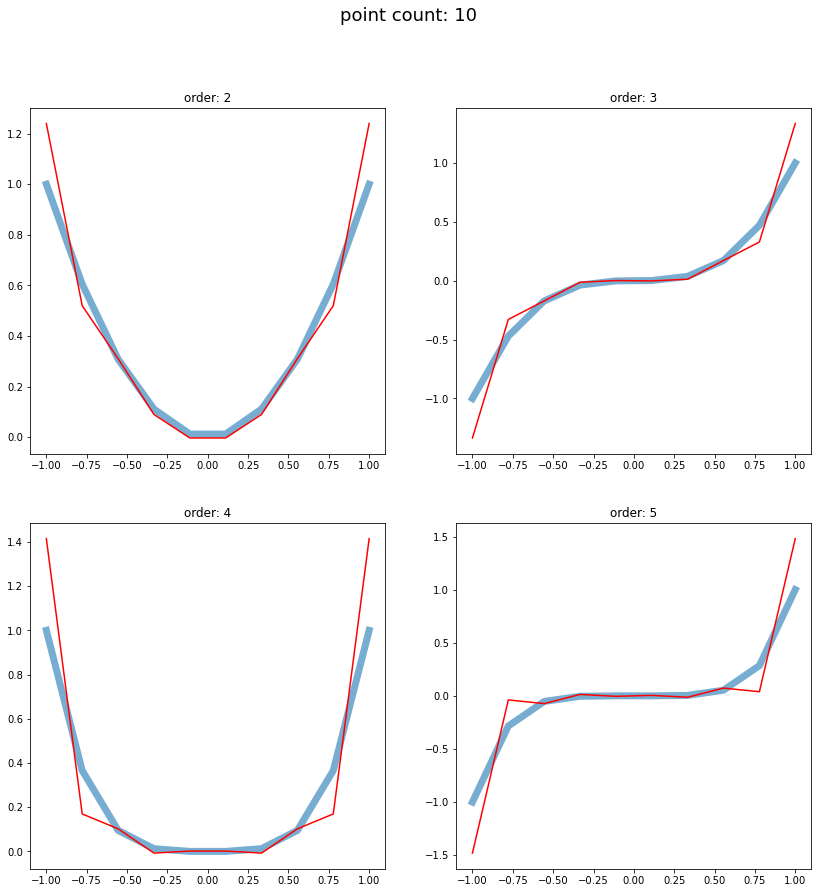

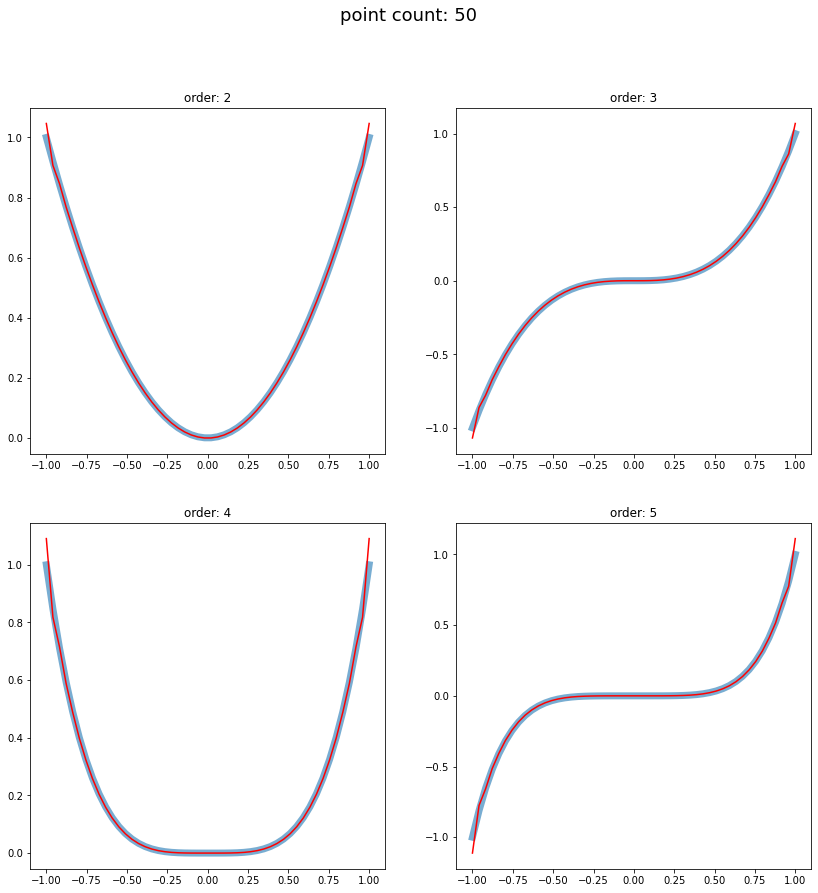

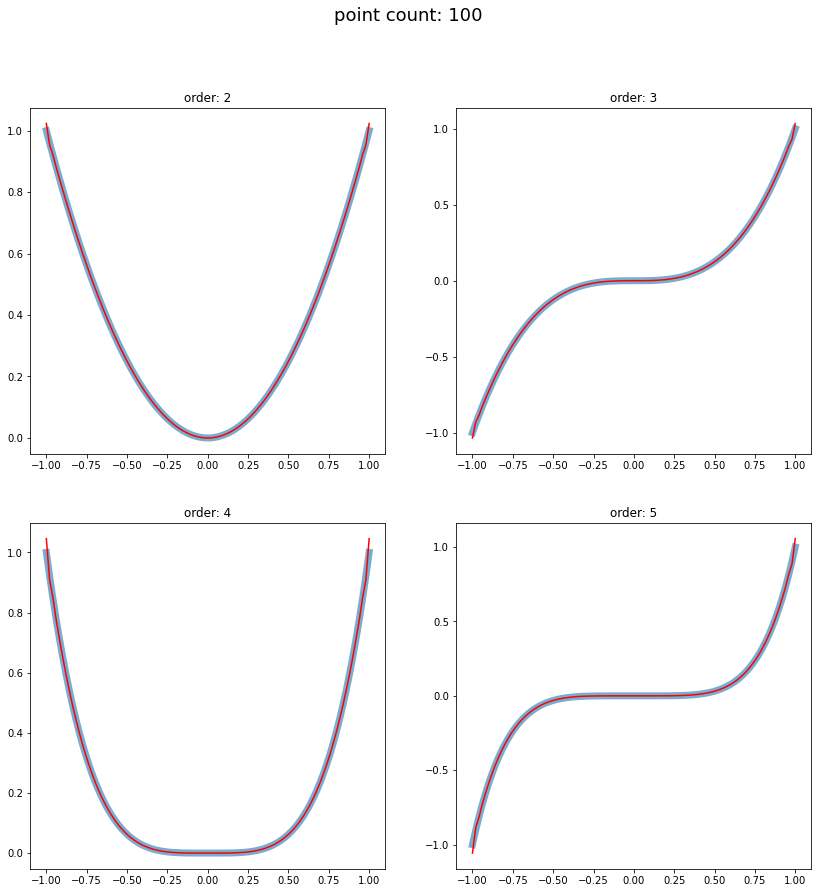

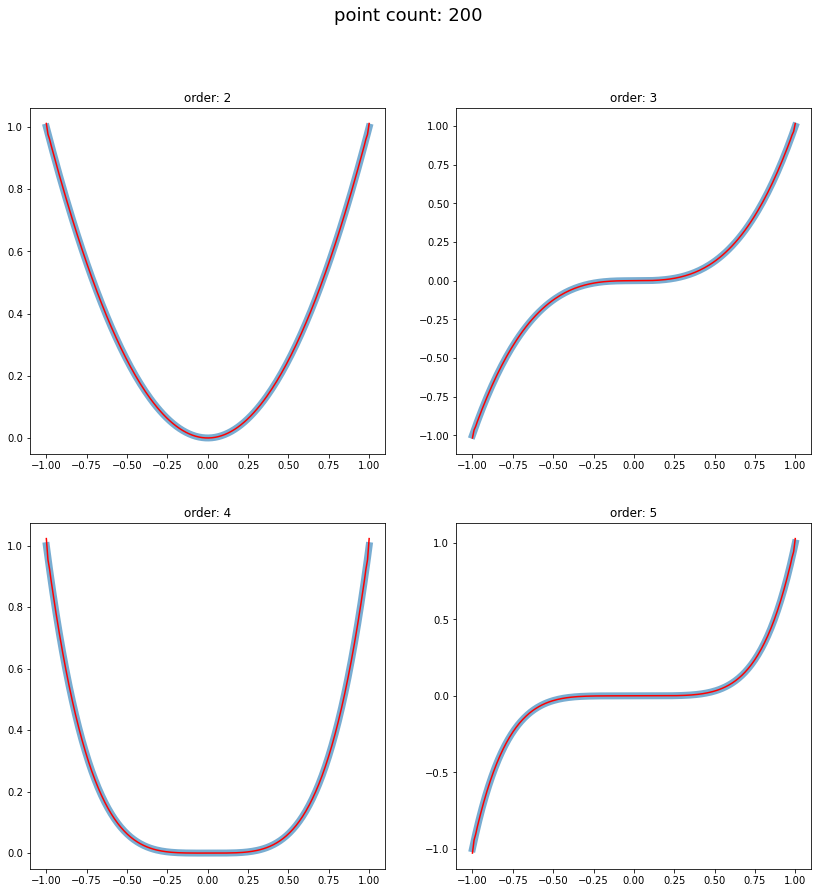

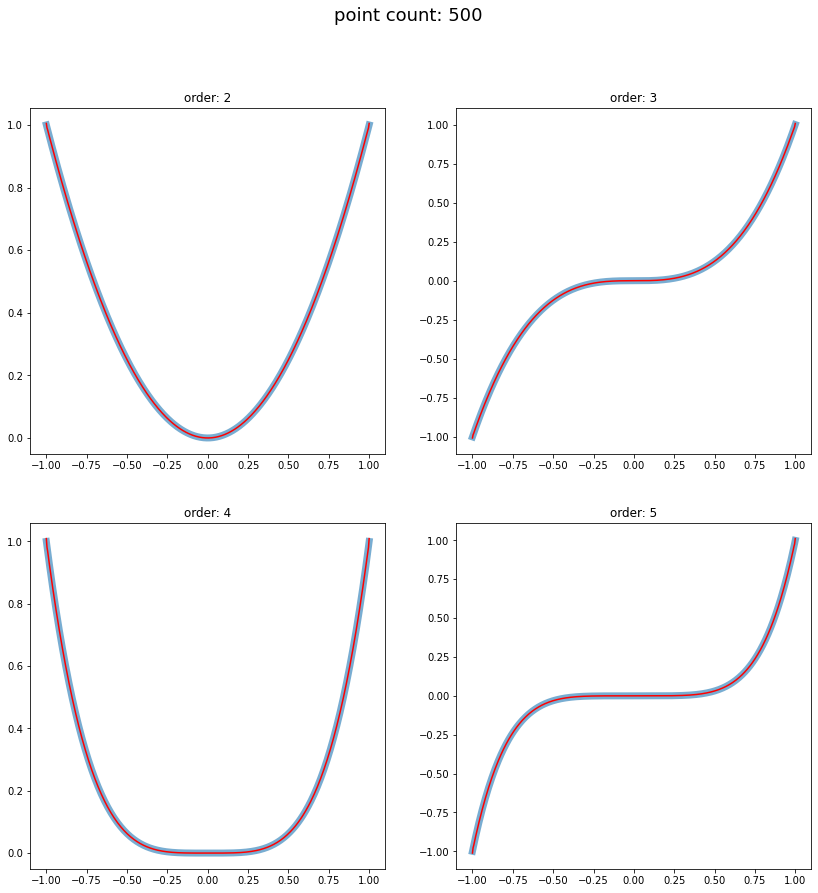

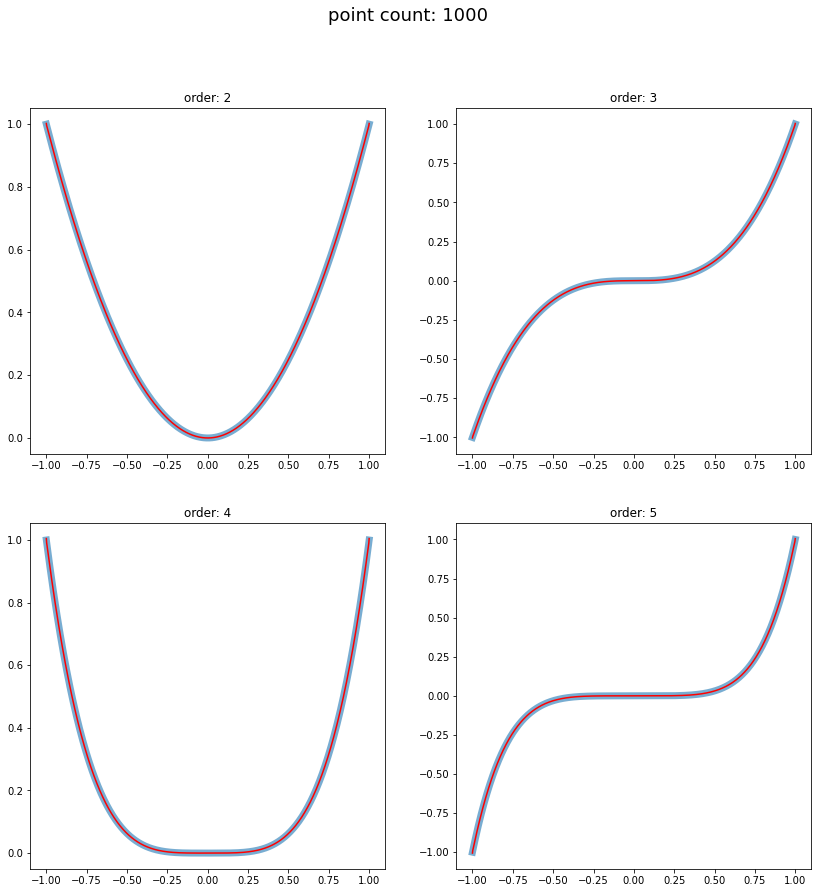

In [75]:
def polynomial(n):
    
    def f(x):
        return x**n
    
    return f

point_count_list = [10, 50 ,100, 200, 500, 1000]
total_error = []
for point_count in point_count_list:
    fig, axs = plt.subplots(2, 2, figsize=(14,14))
    convergence = []
    for order, ax in zip([2, 3, 4, 5], axs.reshape(-1)):
        
        points = np.linspace(-1,1, point_count)
        f = polynomial(order)

        # exact solution
        y = f(points)

        # projection solution
        alpha = solve_system(f, points)

        ax.plot(points, y, linewidth=7, alpha=0.6)
        ax.plot(points, alpha,'r')
        ax.set_title(f'order: {order}')
        error = np.sum(np.abs(alpha-y))
        convergence.append(error)
        
    total_error.append(np.mean(np.array(convergence)))
    fig.suptitle(f'point count: {point_count}', fontsize=18)
    plt.show()


The total error is calculated as the average difference between the approximated and exact solutions over each plot in each point for every point count. 

$$L_{\text{point_count}} = \sum_{i=0}^\text{point_count} |\text{exact}_i - \alpha_i|$$

The plot below illustrates how the mean error decreases as the step count increases.

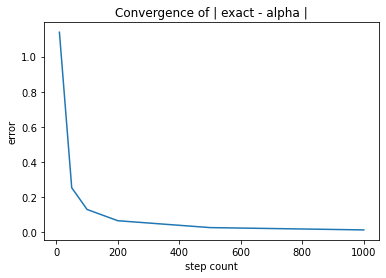

In [76]:
plt.title(f'Convergence of | exact - alpha |')
plt.ylabel('error')
plt.xlabel('step count')
plt.plot(point_count_list, total_error)
plt.show()

# **Discussion**

The convergence plot indicates that the approximation with L2 projection approaches the exact function values for increasingly finer steps. Obviously the tests could be done with more 'difficult' functions with more non-linear characteristics, but the four polynomials already indicate the basic accuracy and convergence rate.
Another point of interest could be to use integration methods more suitable for higher order functions and see how that changes the convergence rate. 